In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

## Hyper-parameters to be tuned

In [2]:
batch_size = 48

In [3]:
#ToTensor: Grayscale image (RGB 0)~255 to 0~Normalize to the range of 1), Normalize: Z-value (RGB mean and standard deviation to 0).Normalize with 5)
transform = transforms.Compose([transforms.ToTensor()])#, transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#Download training data
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


#Download test data
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
#Training dataset: 50,000 RGB images with 32 pixels in height and width
print(train_dataset.data.shape)
(50000, 32, 32, 3)

#Test dataset: 10000 RGB images with 32 pixels in height and width
print(test_dataset.data.shape)
(10000, 32, 32, 3)

#Check the class list
print(train_dataset.classes)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#Classes are often used, so keep them separately
classes = train_dataset.classes

(50000, 32, 32, 3)
(10000, 32, 32, 3)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [7]:
#Implement CNN
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        
        super().__init__()
        self.network = nn.Sequential(
        
        nn.Conv2d(3, 16, 3,1,1),
        nn.ReLU(),    
        nn.Conv2d(16, 16, 3,1,1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        
        nn.Conv2d(16, 32, 3,1,1),
        nn.ReLU(),
        nn.Conv2d(32, 32, 3,1,1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
            
        nn.Conv2d(32, 64, 3,1,1),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3,1,1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
            
        nn.Conv2d(64, 128, 3,1,1),
        nn.ReLU(),
        nn.Conv2d(128, 128, 3,1,1),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d(1),
        
        nn.Flatten(),
        nn.Linear(128, 10))
        
    def forward(self, x):
        return self.network(x)

model = Cifar10CnnModel()
model


Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), 

In [8]:
random_seed = 1487
torch.manual_seed(random_seed);

In [9]:
from torch.utils.data import random_split

val_size = 5000
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)


(45000, 5000)

In [10]:
from torch.utils.data.dataloader import DataLoader
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4,pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size,num_workers=4,pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size,num_workers=4,pin_memory=True)

In [11]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

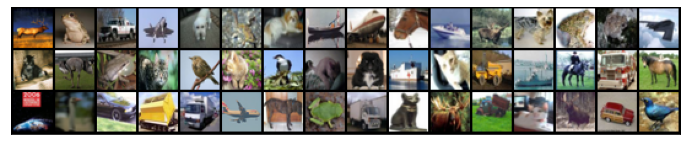

In [12]:
show_batch(train_dl)

### Test output

In [13]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([48, 3, 32, 32])
out.shape: torch.Size([48, 10])
out[0]: tensor([-0.0600,  0.0271, -0.0073,  0.0121, -0.0119,  0.0205,  0.0135, -0.0721,
        -0.0609, -0.0193], grad_fn=<SelectBackward0>)


In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)
test_dl = DeviceDataLoader(test_dl,device)

# Train the model

In [17]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [18]:
model = to_device(Cifar10CnnModel(), device)

In [19]:
evaluate(model, val_dl)

{'val_loss': 2.3040153980255127, 'val_acc': 0.09880952537059784}

In [20]:
evaluate(model, test_dl)

{'val_loss': 2.304152488708496, 'val_acc': 0.09988038241863251}

In [21]:
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
#Cross entropy

num_epochs = 30

lr = 0.000237872310800664
opt_func = torch.optim.Adam


In [22]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    lrs = []
    optimizer = opt_func(model.parameters(), lr)
    
    
    #scheduler_2 = ReduceLROnPlateau(optimizer)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()       
            optimizer.zero_grad()
        
                
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        lrs.append(optimizer.param_groups[0]["lr"])
        
        
        model.epoch_end(epoch, result)
        history.append(result)
        
    #torch.optim.swa_utils.update_bn(loader, swa_model)
    # Use swa_model to make predictions on test data
    #preds = swa_model(test_input)    
    return history,lrs

In [23]:
history,lrs = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.9653, val_loss: 1.7852, val_acc: 0.3272
Epoch [1], train_loss: 1.6640, val_loss: 1.5732, val_acc: 0.4151
Epoch [2], train_loss: 1.5174, val_loss: 1.4905, val_acc: 0.4524
Epoch [3], train_loss: 1.4208, val_loss: 1.3634, val_acc: 0.4950
Epoch [4], train_loss: 1.3366, val_loss: 1.3766, val_acc: 0.4917
Epoch [5], train_loss: 1.2684, val_loss: 1.2595, val_acc: 0.5387
Epoch [6], train_loss: 1.2005, val_loss: 1.2162, val_acc: 0.5627
Epoch [7], train_loss: 1.1435, val_loss: 1.1591, val_acc: 0.5800
Epoch [8], train_loss: 1.0926, val_loss: 1.0932, val_acc: 0.6069
Epoch [9], train_loss: 1.0491, val_loss: 1.0776, val_acc: 0.6103
Epoch [10], train_loss: 1.0137, val_loss: 1.0428, val_acc: 0.6222
Epoch [11], train_loss: 0.9750, val_loss: 1.0198, val_acc: 0.6274
Epoch [12], train_loss: 0.9395, val_loss: 0.9691, val_acc: 0.6512
Epoch [13], train_loss: 0.9117, val_loss: 0.9994, val_acc: 0.6325
Epoch [14], train_loss: 0.8833, val_loss: 0.9230, val_acc: 0.6595
Epoch [15], train_lo

## plot learning rate

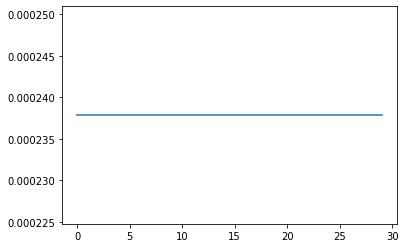

In [24]:
plt.plot(range(num_epochs),lrs)

In [25]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

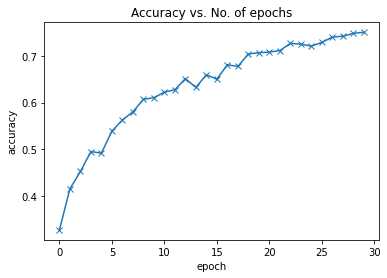

In [26]:
plot_accuracies(history)

In [27]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

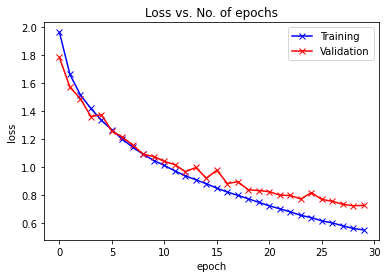

In [28]:
plot_losses(history)

## predict_image

Label: cat , Predicted: cat


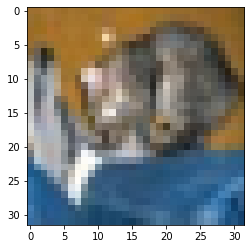

In [29]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
xb = to_device(img.unsqueeze(0), device)
# Get predictions from model
yb = model(xb)
# Pick index with highest probability
_, preds  = torch.max(yb, dim=1)
print('Label:', test_dataset.classes[label], ', Predicted:', test_dataset.classes[preds[0].item()])

In [30]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')

In [31]:
model2 = to_device(Cifar10CnnModel(), device)
model2.load_state_dict(torch.load('cifar10-cnn.pth'))

<All keys matched successfully>

In [32]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size), device)
evaluate(model2, test_loader)

{'val_loss': 0.7290864586830139, 'val_acc': 0.7475079894065857}

# Average of absolute values of activation at each layer, for ALL training data

In [36]:
layer_names = []
for name, layer in model.network.named_children():  
    if isinstance(layer, torch.nn.ReLU):
        layer_names.append(layer) # Names of the layers, so you can have them as part of your plot

In [42]:
abs_avgs_batch = []
for batch, labels in train_dl:
    abs_avgs_layers = []
    for name, layer in model.network.named_children():
        batch = layer(batch)
        if isinstance(layer, torch.nn.ReLU):
            activations = torch.mean(torch.abs(batch)).cpu().detach()
            abs_avgs_layers.append(activations)
    abs_avgs_batch.append(abs_avgs_layers)
        
#abs_avgs.append(np.average(np.absolute(act.numpy().flatten())))

In [51]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(abs_avg.numpy().reshape(-1, 1))

In [52]:
abs_avgs=torch.mean(torch.FloatTensor(abs_avgs_batch),dim=0)
df = pd.DataFrame(list(zip(layer_names, abs_avgs.numpy())), columns = ['Layers',  'Average Absolute Values of Activations'])

In [53]:
pd.DataFrame(list(zip(layer_names,abs_avg.numpy(),scaled)),columns =["Layer#","Average Absolute Values of Activations","normalized to [0,1]"])

,Layer#,Average Absolute Values of Activations,"normalized to [0,1]"
0,ReLU(),0.139574,[0.02403415]
1,ReLU(),0.104119,[0.014246014]
2,ReLU(),0.126771,[0.020499676]
3,ReLU(),0.068106,[0.004303721]
4,ReLU(),0.108329,[0.015408342]
5,ReLU(),0.143759,[0.025189444]
6,ReLU(),0.067615,[0.0041680513]
7,ReLU(),0.179466,[0.035047345]


# Compute the variation of means for all activation layers

In [55]:
torch.var(torch.tensor(scaled))

tensor(0.0693)

In [56]:
torch.var(torch.tensor(abs_avgs))

C:\Users\wanyo\AppData\Local\Temp/ipykernel_13004/859690599.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.var(torch.tensor(abs_avgs))


tensor(0.1393)

## Visulize intermidate activations

In [57]:
def show_activations(layer_name, features):
    activations = torch.mean(torch.abs(features), dim=0).cpu().detach()
    num_activations = activations.shape[0]
    fig = plt.figure(figsize=(30, 5))
    columns = 16
    rows = num_activations // 16 + 1
    plt.title(layer_name)

    for i in range(num_activations):
        fig.add_subplot(rows, columns, int(i)+1)
        plt.imshow(activations[i],interpolation='nearest')
        plt.axis('off')
    plt.grid(False)   

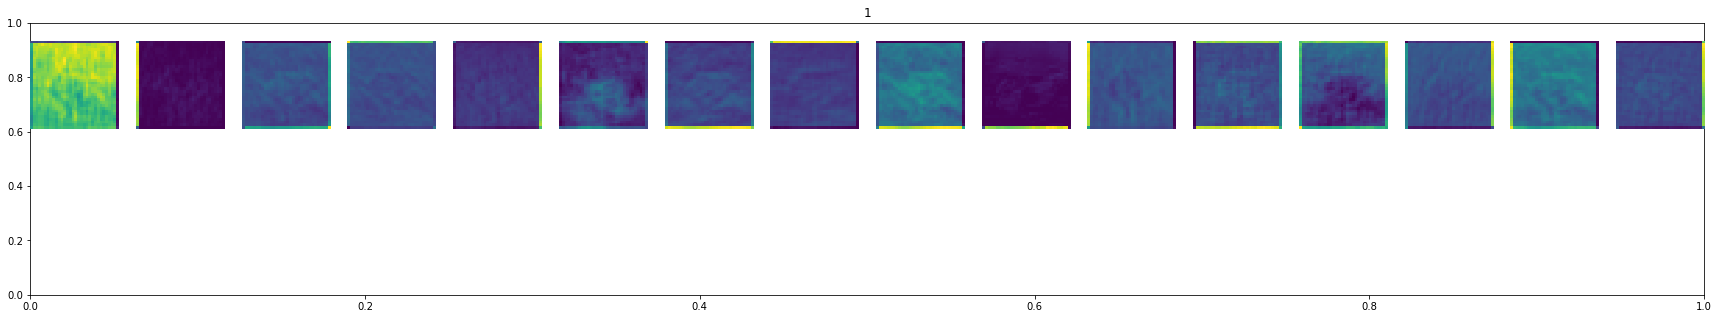

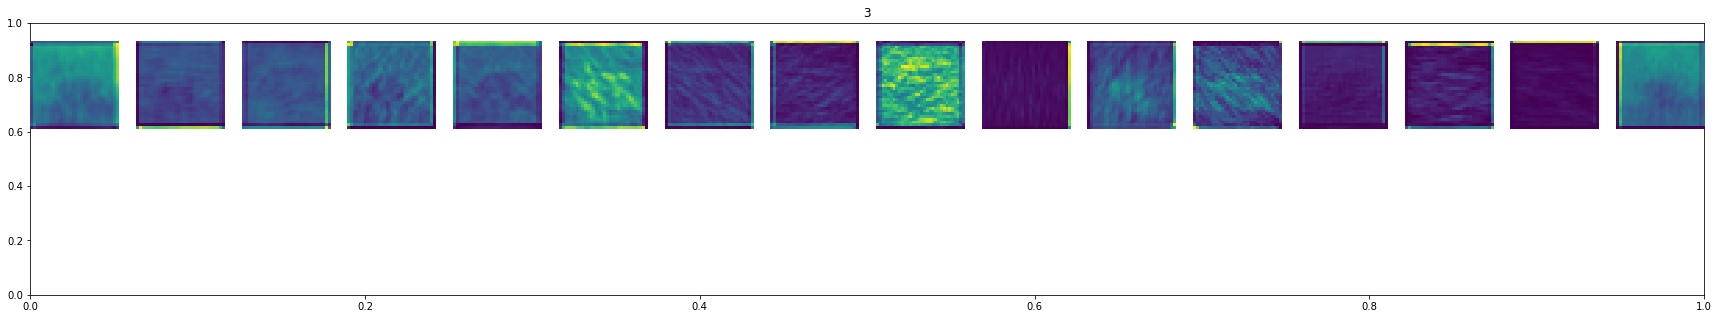

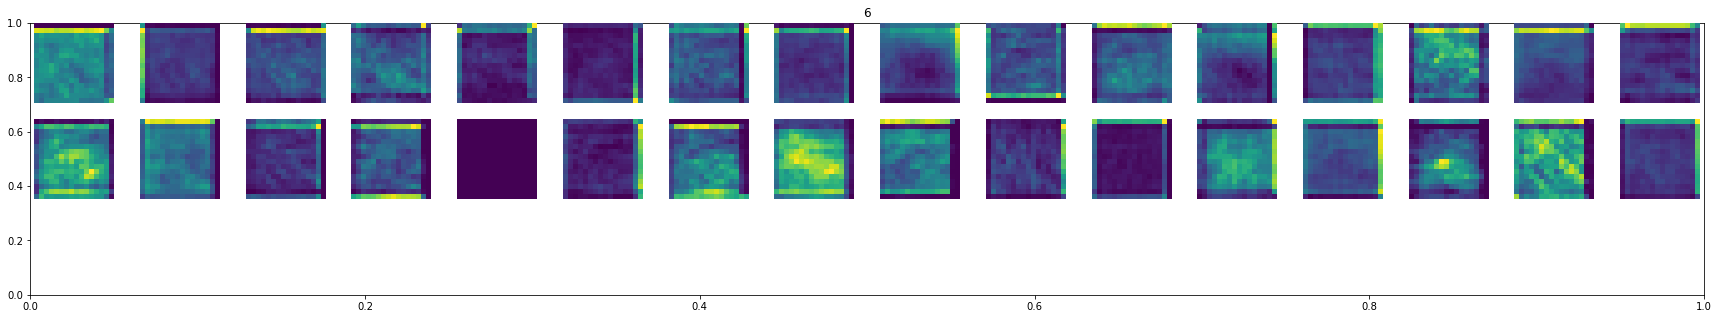

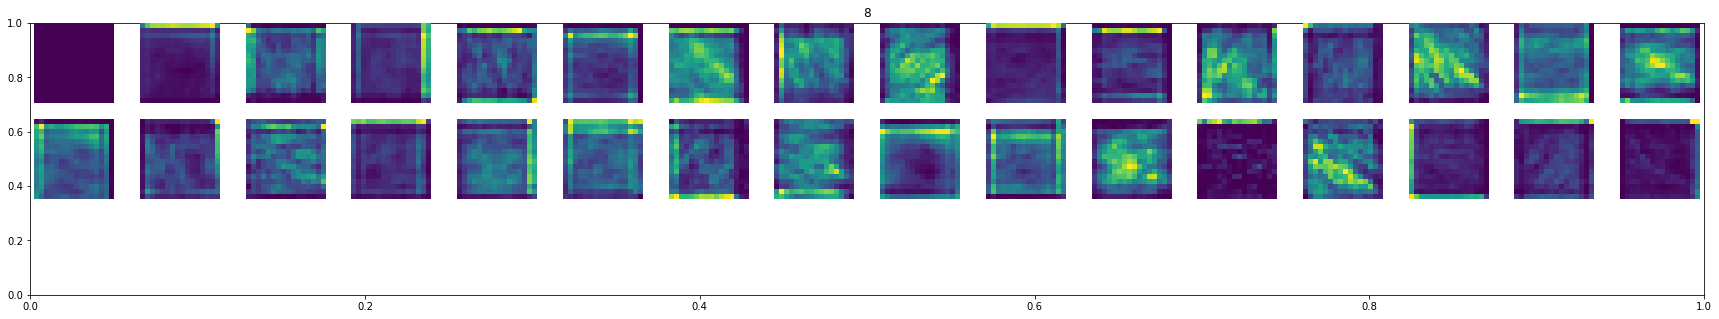

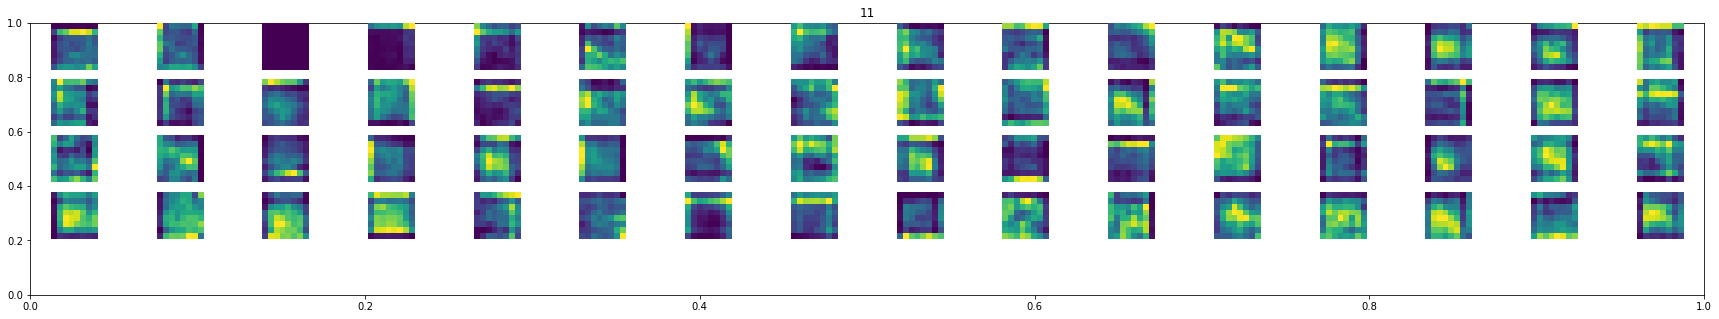

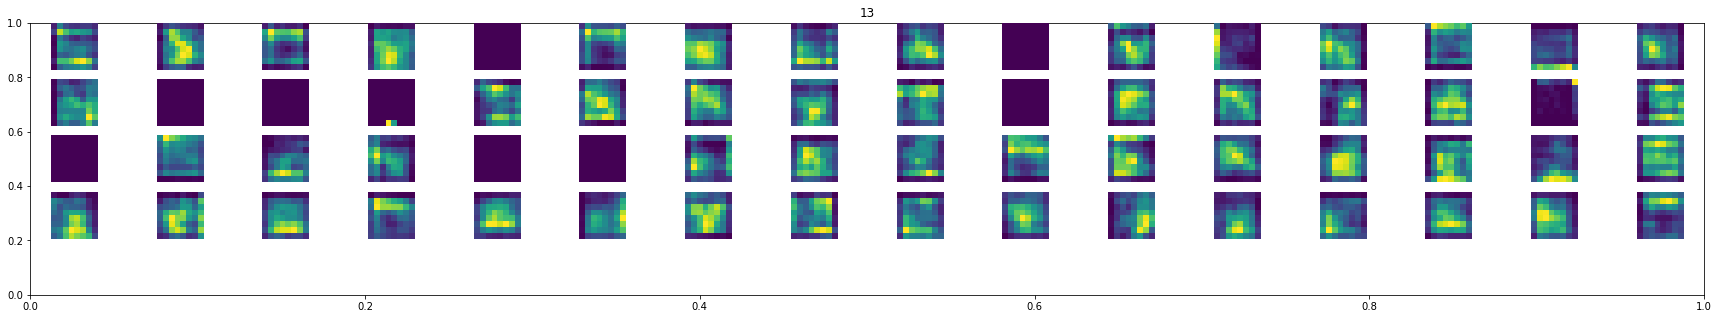

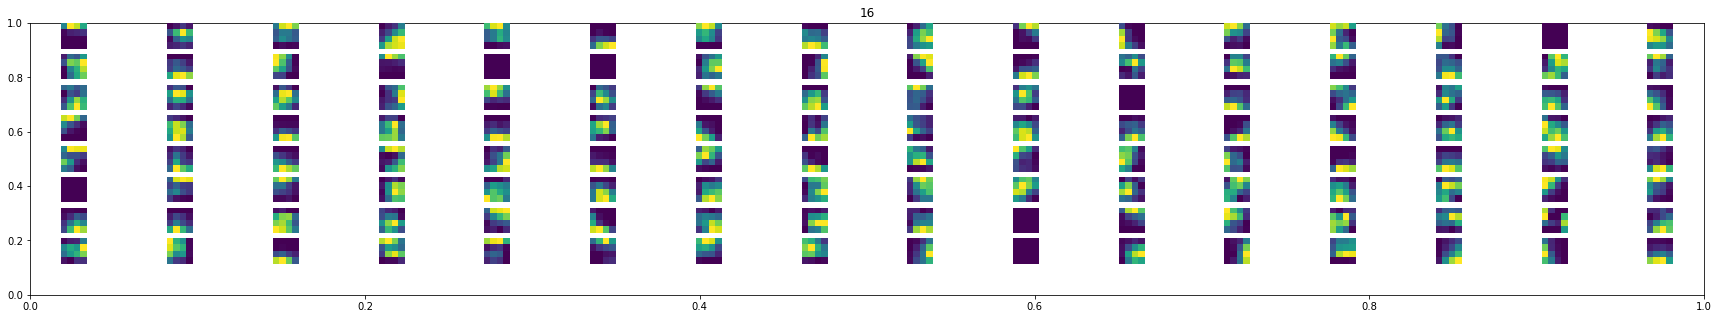

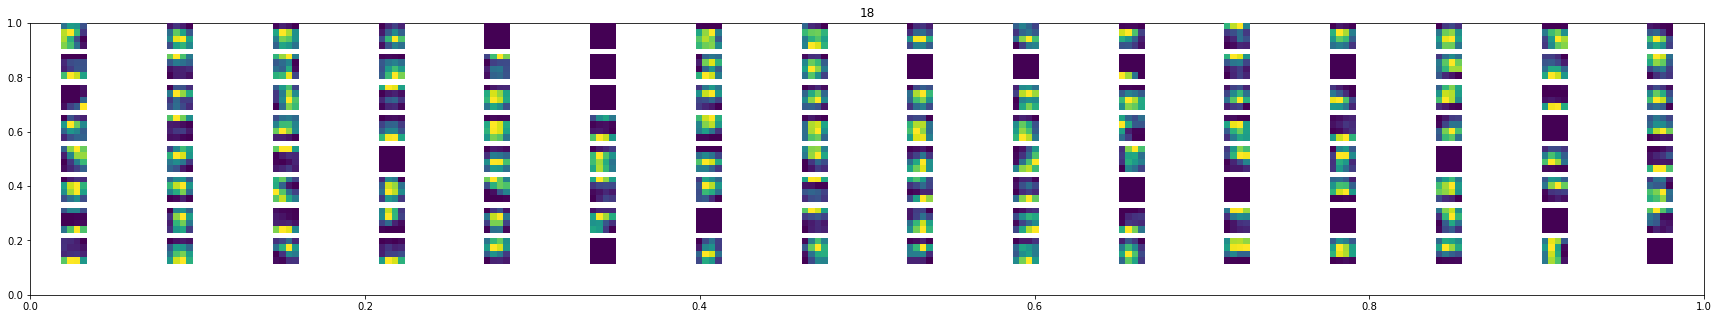

In [59]:
for batch, labels in train_dl:
    for name, layer in model.network.named_children():
        batch = layer(batch)
        if isinstance(layer, torch.nn.ReLU):
            show_activations(name, batch)
    break

In [64]:
a = [1, 2, 3]
b = torch.FloatTensor(a)

In [66]:
type(a)

list

In [ ]:
for for batch, labels in train_dl:
    for name, layer in model.network.named_children():
    #     print(name, layer)
    #     print('input', x.shape)
        x = layer(x)
    #     print('output', x.shape)
    #     print()
        if isinstance(layer, torch.nn.ReLU):
    #         print(layer)
        show_activations(name, x)
    #         break

In [ ]:
#To train
for epoch in range(50):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # add this line
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        #Backpropagation of error
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
        running_loss += loss.item()
    scheduler.step()    
    print('[%d, %5d] loss: %.3f' % (epoch + 1, (i + 1)*batch_size, train_loss))
    running_loss = 0.0
print('Finished Training')

In [ ]:
#Save the model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
#Load test data and display image and correct label
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
#Load the saved model and predict
net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
print(outputs)
value, predicted = torch.max(outputs, 1)
print(value)
print(predicted)

In [ ]:
correct = 0
total = 0

net = Net()
net.load_state_dict(torch.load(PATH))

#Calculate without remembering the gradient (without learning)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))